In [1]:
!pip install pillow matplotlib opencv-python numpy

   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.1/38.6 MB 1.6 MB/s eta 0:00:25
   ---------------------------------------- 0.2/38.6 MB 2.2 MB/s eta 0:00:18
   ---------------------------------------- 0.4/38.6 MB 3.4 MB/s eta 0:00:12
    --------------------------------------- 0.8/38.6 MB 5.1 MB/s eta 0:00:08
   - -------------------------------------- 1.3/38.6 MB 7.3 MB/s eta 0:00:06
   -- ------------------------------------- 2.3/38.6 MB 10.6 MB/s eta 0:00:04
   ---- ----------------------------------- 4.1/38.6 MB 15.4 MB/s eta 0:00:03
   ------ --------------------------------- 6.0/38.6 MB 20.1 MB/s eta 0:00:02
   --------- ------------------------------ 8.8/38.6 MB 26.7 MB/s eta 0:00:02
   ----------- ---------------------------- 11.6/38.6 MB 59.8 MB/s eta 0:00:01
   -------------- ------------------------- 14.0/38.6 MB 72.6 MB/s eta 0:00:01
   --

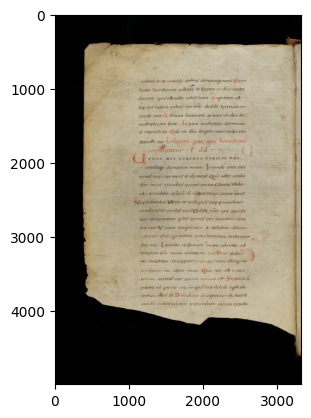

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

# Path to your image
image_path = 'all/img-CS18/img/training/e-codices_csg-0018_050_max.jpg'

# Load and display the image
image = Image.open(image_path)
plt.imshow(image)
plt.show()

In [2]:
import xml.etree.ElementTree as ET

# Path to your annotation file
annotation_path = 'all/PAGE-gt-CS18-TASK-2/TASK-2/training/e-codices_csg-0018_050_max.xml'

# Load and parse the annotation file
tree = ET.parse(annotation_path)
root = tree.getroot()

# Now you can navigate through the XML structure
for page in root.findall('.//Page'):
    print(page.attrib)

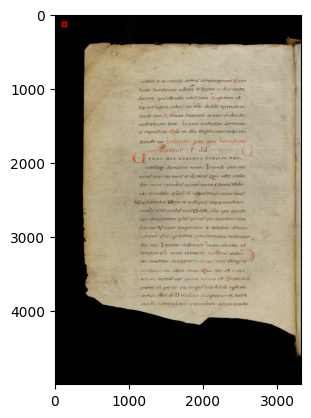

In [4]:
import matplotlib.patches as patches

# Create a figure and a subplot
fig, ax = plt.subplots(1)
ax.imshow(image)

# Example coordinates and dimensions of a bounding box
x, y, w, h = 100, 100, 50, 50  # Replace with actual values

# Create a rectangle patch
rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
plt.show()